In [69]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
from age_balance_analysis import channels, biomass, labelling
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


sns.set_style("whitegrid")

DATA_PATH = Path("../data/lysine_vacule_knockouts")
BIOMASS_DATA_PATH = DATA_PATH / "2024-02-04_exp1-12_signal_filtration_sample_def.tsv"
LABELLING_DATA_PATH = DATA_PATH / "2024-02-19_MS_proteins_EO_3.tsv"
FRACTIONATED_DATA_PATH = DATA_PATH / "2024-02-16_MS_proteins_EO_1.tsv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
unfractionated_df = pd.read_csv(LABELLING_DATA_PATH, delimiter="\t").rename(
    columns={"PG.ProteinGroups": "gene"}
)

fractionated_df = pd.read_csv(FRACTIONATED_DATA_PATH, delimiter="\t").rename(
    columns={"PG.ProteinGroups": "gene"}
)

metadata_df = unfractionated_df.groupby(["experiment", "condition", "strain", "pulse_type", "temp_celsius"]).count().gene.reset_index().set_index("experiment")
metadata_df.rename(columns={"gene": "num_genes"}, inplace=True)
metadata_df.head(20)

condition strain           pulse_type  \
experiment                                                         
1                      Y680 exchange   Y680             exchange   
2                      Y680 exchange   Y680             exchange   
3                      Y679 spike-in   Y679             spike-in   
4                      Y679 spike-in   Y679             spike-in   
5                      Y807 exchange   Y807             exchange   
6                      Y807 exchange   Y807             exchange   
7                      Y808 exchange   Y808             exchange   
8                      Y808 exchange   Y808             exchange   
9           Y679 spike-in timecourse   Y679  spike-in timecourse   
10          Y679 spike-in timecourse   Y679  spike-in timecourse   
11          Y679 spike-in timecourse   Y679  spike-in timecourse   
12          Y679 spike-in timecourse   Y679  spike-in timecourse   

            temp_celsius  num_genes  
experiment                           
1                     30       1688  
2                     30       1688  
3                     30       1814  
4                     30       1814  
5                     30       1829  
6                     30       1829  
7                     30       1793  
8                     30       1793  
9                     30       5192  
10                    30       5192  
11                    37       5056  
12                    37       5056

<Axes: xlabel='1', ylabel='2'>

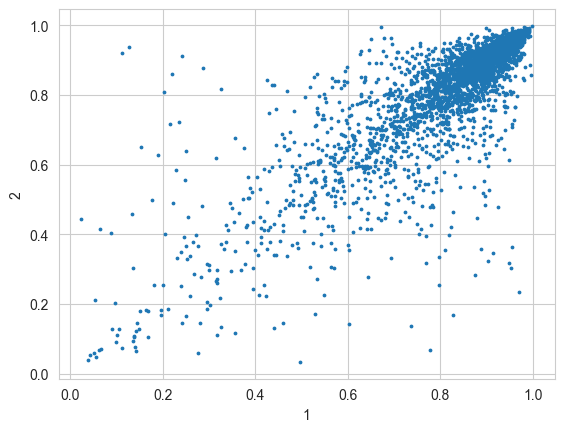

In [44]:
_df = fractionated_df.pivot(index=["condition", "gene_id", "channel"], columns="replicate", values="labelling")
_df.plot.scatter(x=1, y=2, s=3)

## run the K1 vs K2 analysis

In [45]:
free_aa_psis = {}
for experiment, group_df in unfractionated_df.groupby("experiment"):
    adjusted_df = group_df.pivot(index=["gene", "time_min", "replicate"], columns="channel", values="labelling").reset_index()
    c1_values = 1.0 - adjusted_df["K1"].values
    c2_values = 1.0 - adjusted_df["K2"].values
    free_aa_psis[experiment] = channels.find_best_fitting_psi(c1_values, c2_values)
    #fig1 = channels.plot_psi_fitting(c1_values, c2_values, free_aa_psis[experiment])
    print(f"The free lysine pool for {experiment} is estimated to be: {free_aa_psis[experiment]:.03f}")

The free lysine pool for 1 is estimated to be: 0.123
The free lysine pool for 2 is estimated to be: 0.183
The free lysine pool for 3 is estimated to be: 0.133
The free lysine pool for 4 is estimated to be: 0.101
The free lysine pool for 5 is estimated to be: 0.059
The free lysine pool for 6 is estimated to be: 0.077
The free lysine pool for 7 is estimated to be: 0.149
The free lysine pool for 8 is estimated to be: 0.128
The free lysine pool for 9 is estimated to be: 0.185
The free lysine pool for 10 is estimated to be: 0.213
The free lysine pool for 11 is estimated to be: 0.089
The free lysine pool for 12 is estimated to be: 0.122


In [52]:
_df = unfractionated_df[unfractionated_df["channel"] == "K1"].copy()
_df["lnOD"] = -np.log(_df["growth_dilution"])
_df = _df.pivot(index=["experiment", "gene"], columns="lnOD", values="labelling")

In [66]:
result_list = []
for experiment in unfractionated_df.experiment.unique():
    # use the Exp. and protein as the index (the 2 repeats will be pooled together) 
    data_df = _df[_df.index.get_level_values(0) == experiment]
    ksm = labelling.KineticStateModel(initial_pool=free_aa_psis[experiment], n_pools=3, measured_pool_index=2, min_time_points=2)
    result_list.append(ksm.fit_pools(data_df))

[autoreload of _pydevd_bundle.pydevd_frame failed: Traceback (most recent call last):
  File "/home/eladn/git/age-balance-analysis/venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
    
  File "/home/eladn/git/age-balance-analysis/venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
    
  File "/usr/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
    
  File "<frozen importlib._bootstrap>", line 614, in _exec
  File "<frozen importlib._bootstrap>", line 558, in _init_module_attrs
  File "<frozen importlib._bootstrap>", line 398, in cached
  File "<frozen importlib._bootstrap_external>", line 570, in _get_cached
  File "<frozen importlib._bootstrap_external>", line 463, in cache_from_source
  File "<frozen importlib._bootstrap_external>", line 134, in _path_split
  File "<frozen importlib._b

In [55]:
dfs, popts, pcovs = zip(*result_list)
result_df = pd.concat(dfs)
result_df["experiment"], result_df["gene"] = zip(*result_df["index"])
result_df.drop("index", axis=1, inplace=True)
result_df = result_df.join(metadata_df, on="experiment")

popt_dict = {k: v for d in popts for k, v in d.items()}
pcov_dict = {k: v for d in pcovs for k, v in d.items()}

In [56]:
result_df

lysine_psi  n_measurements  n_pools  index_of_measured_pool  mse  \
0       0.132670               1        3                       2  NaN   
1       0.132670               1        3                       2  NaN   
2       0.132670               1        3                       2  NaN   
3       0.132670               1        3                       2  NaN   
4       0.132670               1        3                       2  NaN   
...          ...             ...      ...                     ...  ...   
1648    0.127925               1        3                       2  NaN   
1649    0.127925               1        3                       2  NaN   
1650    0.127925               1        3                       2  NaN   
1651    0.127925               1        3                       2  NaN   
1652    0.127925               1        3                       2  NaN   

      average_age  average_age_sigma  overall_turnover  \
0             NaN                NaN               NaN   
1             NaN                NaN               NaN   
2             NaN                NaN               NaN   
3             NaN                NaN               NaN   
4             NaN                NaN               NaN   
...           ...                ...               ...   
1648          NaN                NaN               NaN   
1649          NaN                NaN               NaN   
1650          NaN                NaN               NaN   
1651          NaN                NaN               NaN   
1652          NaN                NaN               NaN   

      overall_turnover_sigma               error_message  experiment  gene  \
0                        NaN  not enough measured points           3  AAH1   
1                        NaN  not enough measured points           3  AAP1   
2                        NaN  not enough measured points           3  AAT1   
3                        NaN  not enough measured points           3  AAT2   
4                        NaN  not enough measured points           3  ABF1   
...                      ...                         ...         ...   ...   
1648                     NaN  not enough measured points           8  ZPS1   
1649                     NaN  not enough measured points           8  ZRT1   
1650                     NaN  not enough measured points           8  ZTA1   
1651                     NaN  not enough measured points           8  ZUO1   
1652                     NaN  not enough measured points           8  ZWF1   

          condition strain pulse_type  temp_celsius  num_genes  
0     Y679 spike-in   Y679   spike-in            30       1814  
1     Y679 spike-in   Y679   spike-in            30       1814  
2     Y679 spike-in   Y679   spike-in            30       1814  
3     Y679 spike-in   Y679   spike-in            30       1814  
4     Y679 spike-in   Y679   spike-in            30       1814  
...             ...    ...        ...           ...        ...  
1648  Y808 exchange   Y808   exchange            30       1793  
1649  Y808 exchange   Y808   exchange            30       1793  
1650  Y808 exchange   Y808   exchange            30       1793  
1651  Y808 exchange   Y808   exchange            30       1793  
1652  Y808 exchange   Y808   exchange            30       1793  

[20534 rows x 17 columns]

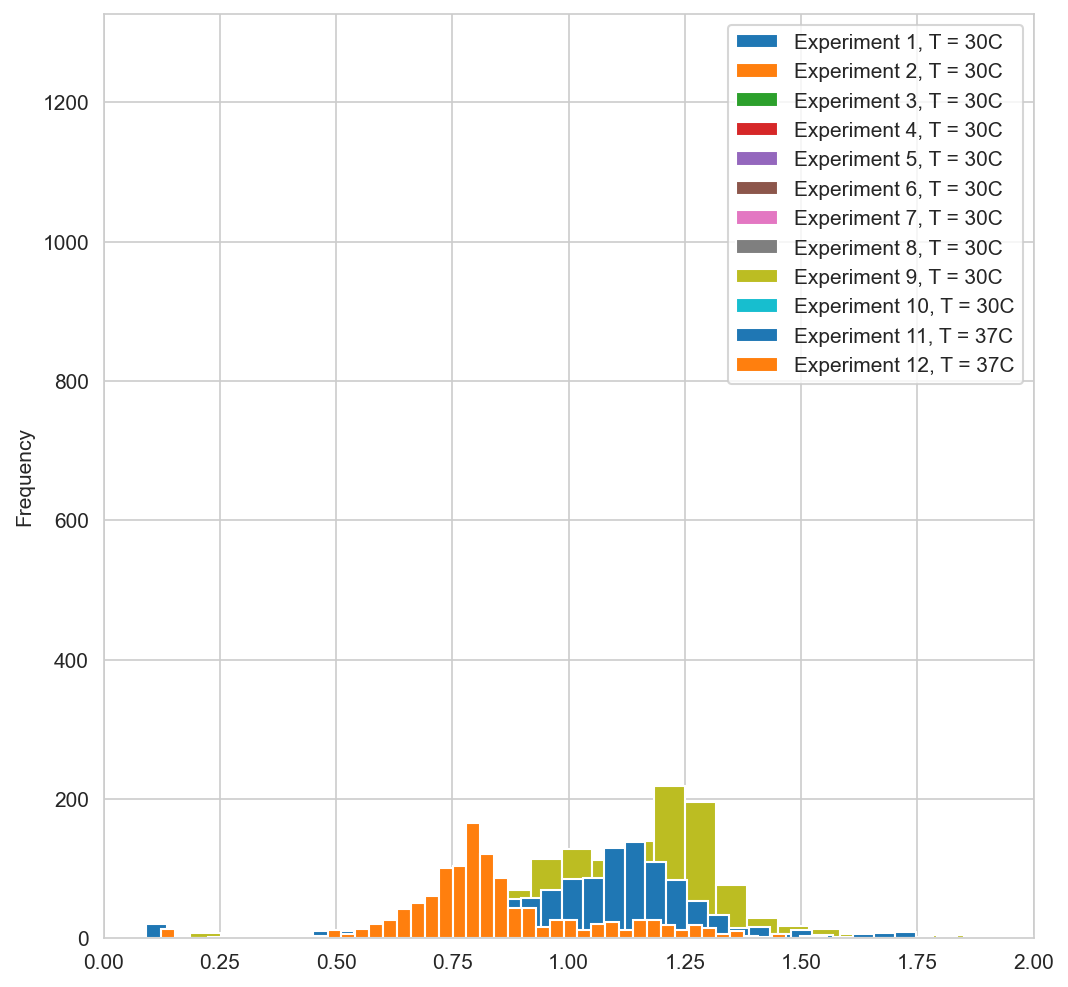

In [58]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
for exp, group_df in result_df.groupby("experiment"):
    temp = group_df.temp_celsius.iat[0]
    group_df.average_age.plot.hist(bins=100, ax=ax, label=f"Experiment {exp}, T = {temp}C")
ax.set_xlim(0, 2)
ax.legend()

In [65]:
result_df[result_df.average_age < 100]

lysine_psi  n_measurements  n_pools  index_of_measured_pool       mse  \
0       0.089472               3        3                       2  0.000790   
1       0.089472               3        3                       2  0.170138   
2       0.089472               3        3                       2  0.003231   
3       0.089472               3        3                       2  0.000234   
5       0.089472               3        3                       2  0.018130   
...          ...             ...      ...                     ...       ...   
1839    0.213436               3        3                       2  0.097604   
1841    0.213436               3        3                       2  0.286280   
1842    0.213436               3        3                       2  0.103003   
1843    0.213436               3        3                       2  0.066501   
1844    0.213436               3        3                       2  0.064294   

      average_age  average_age_sigma  overall_turnover  \
0        0.967406                inf               NaN   
1        0.091462                inf               NaN   
2        1.045173                inf               NaN   
3        1.283058                inf               NaN   
5        0.655577                inf               NaN   
...           ...                ...               ...   
1839     2.213437                inf               NaN   
1841     2.213436                inf               NaN   
1842     2.213439                inf               NaN   
1843     2.213438                inf               NaN   
1844     2.213480                inf               NaN   

      overall_turnover_sigma error_message  experiment  gene  \
0                        NaN                        11  AAH1   
1                        NaN                        11  AAP1   
2                        NaN                        11  AAT1   
3                        NaN                        11  AAT2   
5                        NaN                        11  ABF1   
...                      ...           ...         ...   ...   
1839                     NaN                        10  ZPR1   
1841                     NaN                        10  ZRT1   
1842                     NaN                        10  ZTA1   
1843                     NaN                        10  ZUO1   
1844                     NaN                        10  ZWF1   

                     condition strain           pulse_type  temp_celsius  \
0     Y679 spike-in timecourse   Y679  spike-in timecourse            37   
1     Y679 spike-in timecourse   Y679  spike-in timecourse            37   
2     Y679 spike-in timecourse   Y679  spike-in timecourse            37   
3     Y679 spike-in timecourse   Y679  spike-in timecourse            37   
5     Y679 spike-in timecourse   Y679  spike-in timecourse            37   
...                        ...    ...                  ...           ...   
1839  Y679 spike-in timecourse   Y679  spike-in timecourse            30   
1841  Y679 spike-in timecourse   Y679  spike-in timecourse            30   
1842  Y679 spike-in timecourse   Y679  spike-in timecourse            30   
1843  Y679 spike-in timecourse   Y679  spike-in timecourse            30   
1844  Y679 spike-in timecourse   Y679  spike-in timecourse            30   

      num_genes  
0          5056  
1          5056  
2          5056  
3          5056  
5          5056  
...         ...  
1839       5192  
1841       5192  
1842       5192  
1843       5192  
1844       5192  

[5010 rows x 17 columns]

KeyError: 30

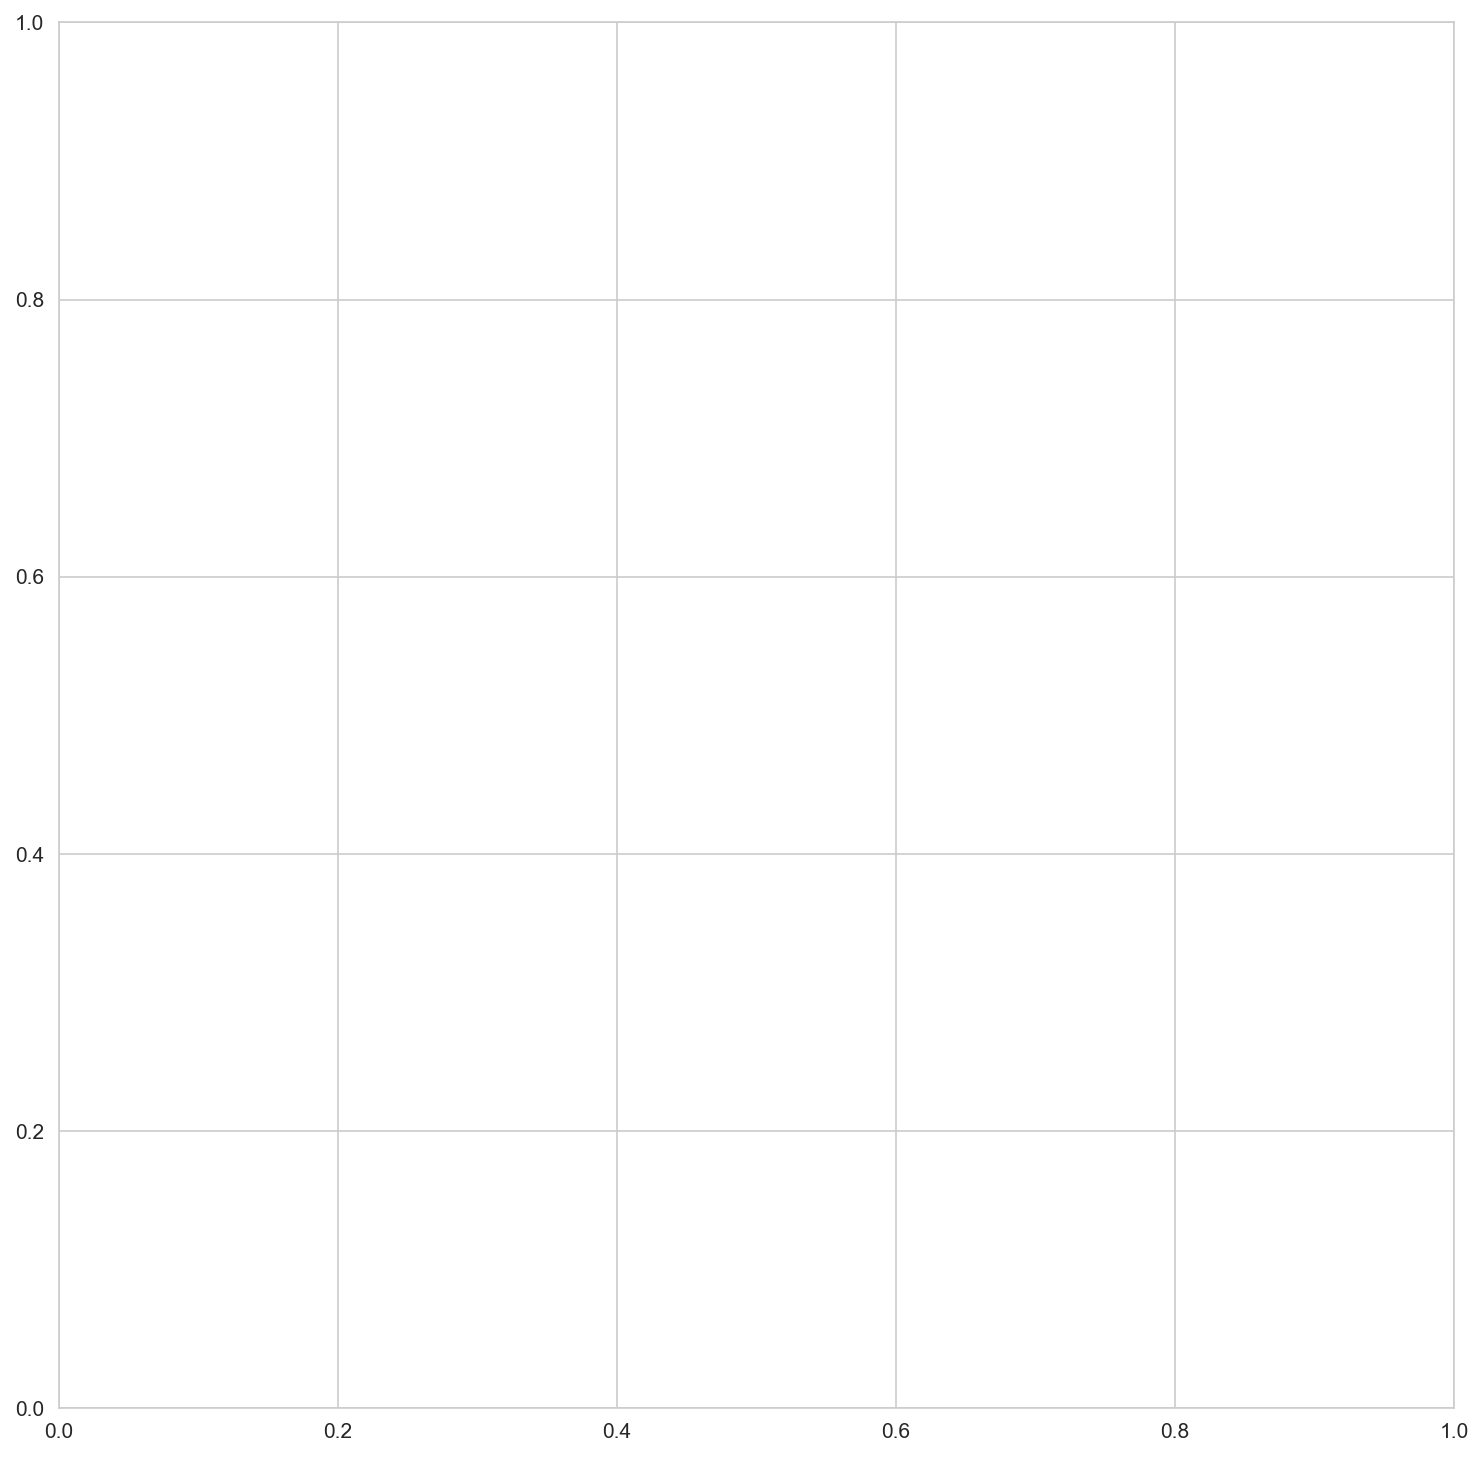

In [60]:
_df = result_df[result_df.average_age_sigma < 0.8]
age_mean_df = _df.pivot(index="gene", columns="temp_celsius", values="average_age")
age_sigma_df = _df.pivot(index="gene", columns="temp_celsius", values="average_age_sigma")

fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=150)
ax.errorbar(x=age_mean_df[30], y=age_mean_df[37], xerr=age_sigma_df[30], yerr=age_sigma_df[37], fmt="o", elinewidth=0.2, alpha=0.6)
ax.plot([0, 2], [0, 2], 'k:')
for idx, row in age_mean_df.iterrows():
    if np.abs(row["30C"] - row["37C"]) > 0.15:
        ax.text(row["30C"], row["37C"], idx)
ax.set_xlim(0.3, 1.25)
ax.set_ylim(0.3, 1.25)
ax.set_title("Y679 spike-in timecourse - age comparison")
ax.set_xlabel("mean age in 30C")
ax.set_ylabel("mean age in 37C")

In [61]:
age_mean_df

Empty DataFrame
Columns: []
Index: []

In [ ]:
indices = [
    ("YKL103C", "30C", "Y679"),
    ("YJL212C", "30C", "Y679"),
    ("YKL103C", "37C", "Y679"),
    ("YJL212C", "37C", "Y679"),
]
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=200)

ksm.max_ln_od_for_plotting = 1.5

xdata = data_df.columns.to_numpy()
for ax, idx in zip(axs.flat, indices):
    ydata = data_df.loc[idx, :].to_numpy()
    taus = popt_dict[idx]
    gene, temp, strain = idx
    ksm.plot_fit(xdata, ydata, taus, ax, label=gene + ", " + temp + ": " + str(taus.round(2)))
fig.tight_layout()